In [10]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt

import lightgbm as lgb

# Data

In [11]:
current_dir = os.getcwd()
data_folder = 'Data'
file_path = os.path.join(current_dir, data_folder, 'Energy_NY_Daily_with_Features.csv')
data = pd.read_csv(file_path)
data = data.rename(columns={'ds': 'date', 'y':'demand'})
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,demand,precip,min_temp,max_temp,avg_temp,temp_80,temp_26,month,season,temp_low,temp_high
0,2012-01-01,118916.0,0.0597,38.78,50.77,46.510000,0,0,1,0,0,0
1,2012-01-02,127270.9,0.0000,33.57,49.78,40.496667,0,0,1,0,0,0
2,2012-01-03,146292.3,0.0000,16.47,33.14,26.672500,0,0,1,0,1,0
3,2012-01-04,152070.4,0.0000,13.40,31.83,20.585000,0,1,1,0,1,0
4,2012-01-05,147125.9,0.0000,27.31,39.16,33.577500,0,0,1,0,0,0


In [20]:
# Time features
data['weekday'] = data['date'].dt.dayofweek+1
data['week'] = data['date'].dt.week
data.tail()

,date,demand,precip,min_temp,max_temp,avg_temp,temp_80,temp_26,month,season,temp_low,temp_high,weekday,week
2043,2017-08-05,159779.923,0.1351,68.05,80.39,74.172917,0,0,8,2,0,0,6,31
2044,2017-08-06,136856.677,0.0000,60.96,78.62,70.129167,0,0,8,2,0,0,7,31
2045,2017-08-07,153555.700,0.5096,65.66,70.86,68.203750,0,0,8,2,0,0,1,32
2046,2017-08-08,155319.025,0.0000,66.17,79.24,71.039167,0,0,8,2,0,0,2,32
2047,2017-08-09,163466.692,1.1407,63.79,84.61,73.852500,0,0,8,2,0,0,3,32


In [148]:
# Train-test split
#train = data[data['date']<='2017-06-30']
#test = data[data['date']>'2017-06-30']
train = data[data['date']<='2017-05-31']
test = data[(data['date']>'2017-05-31') & (data['date']<='2017-06-30')]
valid = data[data['date']>'2017-06-30'] # validation dataset
train_valid = data[data['date']<='2017-06-30'] # for validation dataset
                                           
print('Train shape:', train.shape)
print('Test shape:', test.shape)

cols = data.columns
cols = cols.drop(['date', 'demand'])

train_data = lgb.Dataset(train[cols], label = train['demand'])
test_data = lgb.Dataset(test [cols], label = test['demand'], reference=train_data)
train_data_valid = lgb.Dataset(train2[cols], label = train2['demand']) # for validation dataset


Train shape: (1978, 14)
Test shape: (30, 14)


# Initial Model

In [149]:
params = {'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.1,
          'max_depth': -1, #no limit
#           'num_leaves': 30,
          'feature_fraction': 0.8,
          'subsample': 0.8}

model = lgb.train(params, train_data,
                  num_boost_round=500,
                  early_stopping_rounds=10,
                  valid_sets=[test_data],
                  valid_names=['valid'],
                  verbose_eval = 100)

pred = model.predict(test[cols])

test_rmse = model.best_score['valid']['rmse']
train_rmse = np.sqrt(((train['demand']-model.predict(train[cols]))**2).mean())
test_mape = (abs(test['demand']-pred)/test['demand']).mean()
print('Train RMSE: ', train_rmse)
print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)

# Testing on validation set
# Adding latest data to the fit
n = model.best_iteration
model2 = lgb.train(params, train_data2,
                  num_boost_round = n,
                  verbose_eval=5)

pred2 = model2.predict(valid[cols])
valid_rmse =np.sqrt(((valid['demand']-pred2)**2).mean())
valid_mape = (abs(valid['demand']-pred2)/valid['demand']).mean()
print('Valid RMSE:', valid_rmse)
print('Valid MAPE:', valid_mape)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid's rmse: 9380.88
Train RMSE:  5012.845117215468
Test RMSE: 9380.884079149291
Test MAPE: 0.04643087136289457
Valid RMSE: 6796.75663291055
Valid MAPE: 0.030901234065108564


## Tuning parameters & Cross-Validation

In [207]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import forest_minimize, gp_minimize

def train_evaluate(search_params):
    
    params = {'objective': 'regression',
              'metric': 'rmse',
              **search_params}
    scores = []
    
    # Cross validation on three periods: jan 2017, mar 2017, jun 2017
    for d1 in ['2016-12-31', '2017-02-28', '2017-05-31']:
        d2= pd.date_range(start = d1, periods = 2, freq = '1M').max()
        trn = data[data['date']<=d1]
        tst = data[(data['date']>d1) & (data['date']<=d2)]

        trn_data = lgb.Dataset(trn[cols], label = trn['demand'])
        tst_data = lgb.Dataset(tst[cols], label = tst['demand'], reference=trn_data)

        model = lgb.train(params, trn_data,
                          num_boost_round=1000,
                          early_stopping_rounds=10,
                          valid_sets=[tst_data],
                          valid_names=['test'],
                          verbose_eval = -1)

        scores += [model.best_score['test']['rmse']]
    return np.mean(scores)

# Set wider bounds in the beginning. Narrow down later on.
space = [
    Real(0.01, 0.2, name='learning_rate', prior='log-uniform'),
    Integer(1, 10, name='max_depth'),
#    Integer(2, 100, name='num_leaves'),
    Real(0.1, 1.0, name='feature_fraction', prior='uniform'),
    Real(0.1, 1.0, name='subsample', prior='uniform')]

@use_named_args(space)
def objective(**params):
    return train_evaluate(params)

results = forest_minimize(objective, space, n_calls=50, n_random_starts=10)
#results = gp_minimize(objective, space, n_calls=50, n_random_starts=10)
best_rmse = results.fun
best_params = results.x

print('Best rmse:', best_rmse)
print('Best params:', best_params)
      

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	test's rmse: 2730.82
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	test's rmse: 2629.89
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	test's rmse: 9550.42
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[159]	test's rmse: 2678.15
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[106]	test's rmse: 2784.41
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	test's rmse: 9441.69
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	test's rmse: 2560.51
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	test's rmse: 2757.47
Training until valida

Early stopping, best iteration is:
[297]	test's rmse: 2412.33
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[334]	test's rmse: 9047.83
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[434]	test's rmse: 2768.16
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[218]	test's rmse: 2271.71
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[223]	test's rmse: 8144.42
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[233]	test's rmse: 2724.64
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[126]	test's rmse: 2192.43
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	test's rmse: 8300.45
Training until validation scores don't improve for 10 rounds
Early stopping, 

Early stopping, best iteration is:
[210]	test's rmse: 8168.54
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[505]	test's rmse: 2818.88
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[311]	test's rmse: 2174.78
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[308]	test's rmse: 8535.86
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	test's rmse: 3264.13
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[829]	test's rmse: 2489.06
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[917]	test's rmse: 8899.09
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[615]	test's rmse: 2870.93
Training until validation scores don't improve for 10 rounds
Ea

## Final Model & Validation

In [264]:
# Model evaluation with rounded up params. Defining n of rounds for final model:
params = {'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.08,
          'max_depth': 3,
          'feature_fraction': 0.8,
          'subsample': 0.8}

scores=[]
best_iter=[]

for d1 in ['2016-12-31', '2017-02-28', '2017-05-31']:
        d2= pd.date_range(start = d1, periods = 2, freq = '1M').max()
        trn = data[data['date']<=d1]
        tst = data[(data['date']>d1) & (data['date']<=d2)]

        trn_data = lgb.Dataset(trn[cols], label = trn['demand'])
        tst_data = lgb.Dataset(tst[cols], label = tst['demand'], reference=trn_data)

        model = lgb.train(params, trn_data,
                          num_boost_round=1000,
                          early_stopping_rounds=10,
                          valid_sets=[tst_data],
                          valid_names=['test'],
                          verbose_eval = -1)

        scores += [model.best_score['test']['rmse']]
        best_iter += [model.best_iteration]
nrounds = np.max(best_iter)

print('Scores:', scores)
print('Best n of rounds:', best_iter)
print()
print('CV RMSE: ', np.mean(scores))
print('Max best n of rounds:', nrounds)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[78]	test's rmse: 2674.53
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	test's rmse: 2191.57
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	test's rmse: 7960.23
Scores: [2674.5280681149634, 2191.5658927013706, 7960.232833355369]
Best n of rounds: [78, 47, 43]

CV RMSE:  4275.442264723901
Max best n of rounds: 78


In [266]:
# FINAL MODEL fit and validation

model_final = lgb.train(params, train_data_valid,
                  num_boost_round=nrounds
                  )

pred = model_final.predict(valid[cols])
valid_rmse =np.sqrt(((valid['demand']-pred)**2).mean())
valid_mape = (abs(valid['demand']-pred)/valid['demand']).mean()
print('Valid RMSE:', valid_rmse)
print('Valid MAPE:', valid_mape)


Valid RMSE: 7272.099708694156
Valid MAPE: 0.031856067799052055


## VIZ

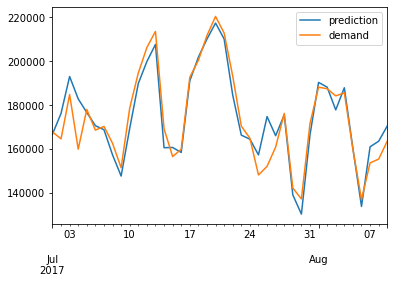

In [267]:
forecast_range = pd.date_range(start = valid['date'].min(), periods = valid.shape[0], freq = 'D')
forecast_df = pd.DataFrame(pred, index = forecast_range, columns = ['prediction'])
forecast_df['demand'] = np.array(valid['demand'])
forecast_df.plot()

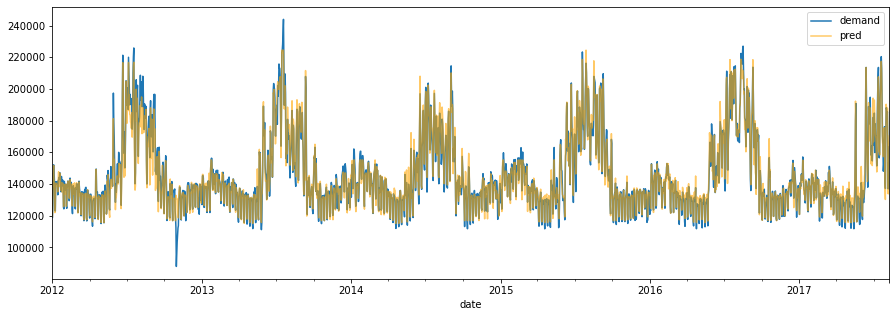

In [276]:
modelfit = data[['date', 'demand']].set_index('date')
modelfit.plot(figsize = (15,5))
modelfit['pred'] = model_final.predict(data[cols])
modelfit['pred'].plot(color='orange', alpha=0.6, legend=True)
plt.show()